# Antarctica Synthetic

Apply EQS GB to the Antarctica synthetic data.

In [1]:
import pandas as pd
import pygmt
import verde as vd
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import itertools
import synthetics

Load data from an Antarctic magnetic survey

In [2]:
df = pd.read_csv('../data/victoria_land.csv')
df

C:\Users\iuppal\AppData\Local\Temp\ipykernel_8388\1680060348.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/victoria_land.csv')


,Line,Date,Time,Lat,Lon,Easting,Northing,Upward,Height_WGS84,Project,MagGol
2040251,LG1L10.1,1991/01/01,NaN,-74.68848,162.09804,414493.389433,-8.290939e+06,2700.0,2700.0,GITARA,-62.476330
2040252,LG1L10.1,1991/01/01,NaN,-74.68859,162.09933,414531.970602,-8.290949e+06,2700.0,2700.0,GITARA,-62.500752
2040253,LG1L10.1,1991/01/01,NaN,-74.68869,162.10062,414570.496834,-8.290959e+06,2700.0,2700.0,GITARA,-62.529617
2040254,LG1L10.1,1991/01/01,NaN,-74.68879,162.10188,414608.139331,-8.290968e+06,2700.0,2700.0,GITARA,-62.566840
2040255,LG1L10.1,1991/01/01,NaN,-74.68889,162.10316,414646.370247,-8.290977e+06,2700.0,2700.0,GITARA,-62.610168
...,...,...,...,...,...,...,...,...,...,...,...
4294661,LNVT91,1993/02/01,NaN,-76.12685,161.77679,413770.034807,-8.451695e+06,2700.0,2700.0,GITARA,25.993211
4294662,LNVT91,1993/02/01,NaN,-76.12732,161.77625,413758.465517,-8.451748e+06,2700.0,2700.0,GITARA,25.811278
4294663,LNVT91,1993/02/01,NaN,-76.12778,161.77568,413746.034477,-8.451800e+06,2700.0,2700.0,GITARA,25.631227
4294664,LNVT91,1993/02/01,NaN,-76.12824,161.77513,413734.138943,-8.451852e+06,2700.0,2700.0,GITARA,25.452877


In [3]:
easting = df.Easting.to_numpy()
northing = df.Northing.to_numpy()
upwards = df.Upward.to_numpy()
coordinates = [easting, northing, upwards]

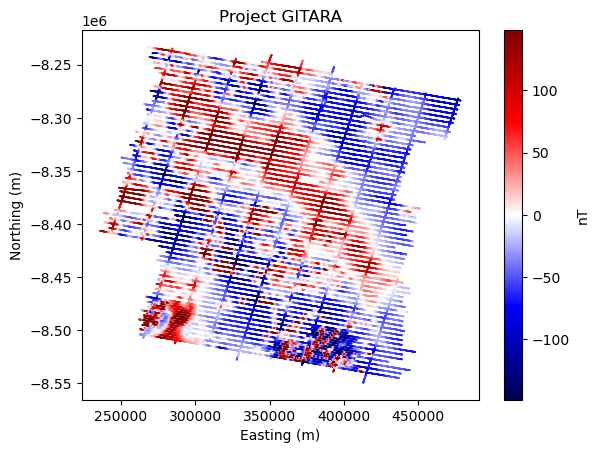

In [4]:
plt.figure()
scale = np.nanpercentile(df.MagGol, 95)
plt.scatter(*coordinates[:2], c=df.MagGol, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.title("Project GITARA")
plt.show()

Create a synthetic source model based on the Antarctic magnetic survey.

In [5]:
field_direction = eqs.angles_to_vector(84, 122, 1)

In [6]:
largest_anomaly_direction = [65, 75]
grid_anomaly_direction = [68, 80]
scatter_anomaly_direction = [40, 45]
north_anomaly_direction = [35, 70]
south_anomaly_direction = [50, 20]
regional_direction = [-88, 78]

source_coordinates, dipole_moments = synthetics.complicated_synthetic(
    largest_anomaly=largest_anomaly_direction,
    grid_anomaly=grid_anomaly_direction,
    scatter_anomaly=scatter_anomaly_direction,
    north_anomaly=north_anomaly_direction,
    south_anomaly=scatter_anomaly_direction,
    regional=regional_direction,
)

In [7]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [8]:
tfa = eqs.total_field_anomaly(b_field, field_direction)
bnorm = eqs.magnetic_field_norm(b_field)

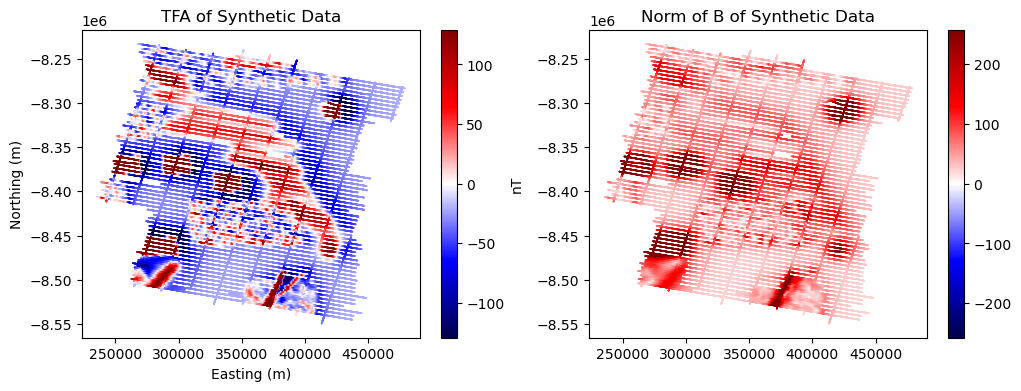

In [9]:
plt.figure(figsize=(12,4))
scale = np.nanpercentile(tfa, 95)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
scale_bnorm = np.nanpercentile(bnorm, 95)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="seismic",s=0.01, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

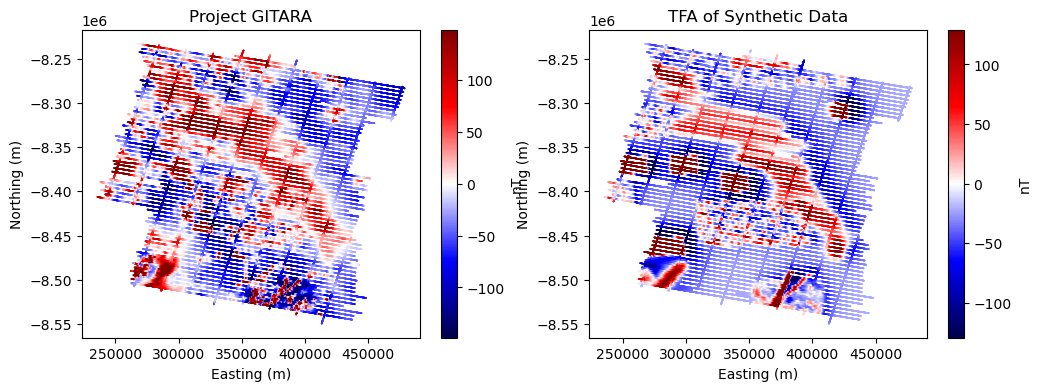

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
scale = np.nanpercentile(df.MagGol, 95)
plt.scatter(*coordinates[:2], c=df.MagGol, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.title("Project GITARA")

plt.subplot(1,2,2)
scale = np.nanpercentile(tfa, 95)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
scale_bnorm = np.nanpercentile(bnorm, 95)

plt.show()

## Fit deep source

In [15]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e4, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

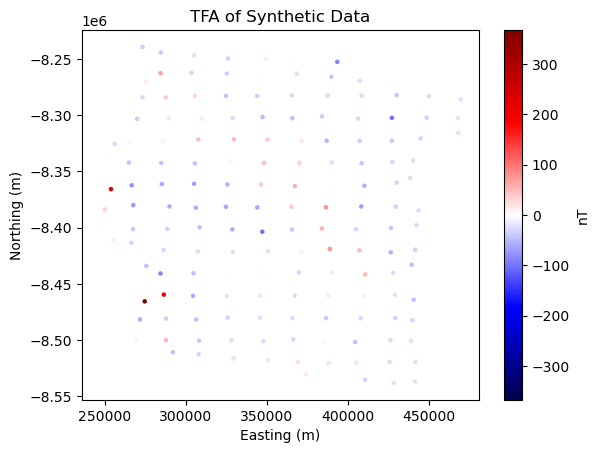

In [16]:
plt.figure()
scale = vd.maxabs(tfa_blocked)
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [17]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -65555.3191082565
CPU times: total: 31.2 ms
Wall time: 7.99 ms


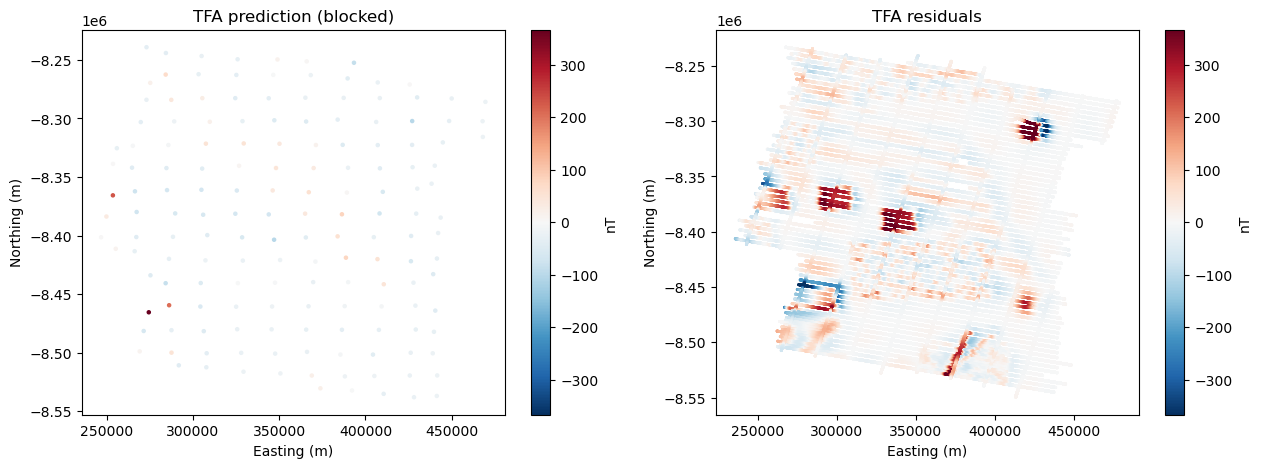

In [18]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coords_blocked[:2], c=tfa_deep_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA prediction (blocked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="RdBu_r", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep residuals with gradient-boosted sources

In [62]:
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, damping=1e-1, depth=500)

In [63]:
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by StandardScaler.

## Run the the code in the fit function to figure out what is causing the error

In [56]:
import sklearn.utils
import sklearn.utils.validation

In [60]:
coordinates, data, weights = vd.base.check_fit_input(coordinates, tfa_residuals, weights=None)
eqs_shallow.region_ = vd.get_region(coordinates[:2])
coordinates = vd.base.n_1d_arrays(coordinates, 3)
eqs_shallow.dipole_coordinates_ = eqs_shallow._build_points(coordinates)
dipole_moment_direction = eqs.angles_to_vector(eqs_shallow.dipole_inclination, eqs_shallow.dipole_declination, 1,)
if eqs_shallow.window_size is None:
    area = (eqs_shallow.region_[1] - eqs_shallow.region_[0]) * (eqs_shallow.region_[3] - eqs_shallow.region_[2])
    ndata = data.size
    points_per_m2 = ndata / area
    window_area = 5e3 / points_per_m2
    eqs_shallow.window_size_ = np.sqrt(window_area)
else:
    eqs_shallow.window_size_ = eqs_shallow.window_size

In [65]:
_, dipole_windows = vd.rolling_window(
    eqs_shallow.dipole_coordinates_,
    region=eqs_shallow.region_,
    size=eqs_shallow.window_size_,
    spacing=eqs_shallow.window_size_ / 2,
)
print(dipole_windows)
_, data_windows = vd.rolling_window(
    coordinates,
    region=eqs_shallow.region_,
    size=eqs_shallow.window_size_,
    spacing=eqs_shallow.window_size_ / 2
)
dipole_windows = [i[0] for i in dipole_windows.ravel()]
data_windows = [i[0] for i in data_windows.ravel()]
residuals = data.copy()
moment_amplitude = np.zeros_like(eqs_shallow.dipole_coordinates_[0])
window_indices = list(range(len(data_windows)))
sklearn.utils.check_random_state(eqs_shallow.random_state).shuffle(window_indices)
for window in window_indices:
    dipole_window, data_window = dipole_windows[window], data_windows[window]
    coords_chunk = tuple(c[data_window] for c in coordinates)
    dipole_chunk = tuple(c[dipole_window] for c in eqs_shallow.dipole_coordinates_)
    if weights is not None:
        weights_chunk = weights[data_window]
    else:
        weights_chunk = None
    jacobian = eqs_shallow.jacobian(
        coords_chunk, dipole_chunk, dipole_moment_direction, field_direction,
    )
    moment_amplitude_chunk = vd.base.least_squares(
        jacobian, residuals[data_window], weights_chunk, eqs_shallow.damping,
    )

[[(array([], dtype=int64),) (array([], dtype=int64),)
  (array([ 942,  943,  999, 1000, 1001, 1002, 1003, 1055, 1056, 1057, 1058,
         1059, 1060, 1116, 1117], dtype=int64),)
  (array([ 288,  320,  361,  408,  452,  453,  498,  547,  705,  706,  707,
          708,  761,  762,  763,  764,  765,  819,  820,  821,  822,  823,
          883,  884,  885,  886,  887,  888,  942,  943,  944,  945,  946,
          947,  948,  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007,
         1008, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064,
         1065, 1116, 1117, 1121, 1122, 1123], dtype=int64),)
  (array([ 288,  320,  361,  408,  452,  453,  454,  498,  499,  500,  501,
          502,  503,  547,  548,  549,  550,  551,  552,  600,  601,  602,
          603,  604,  605,  606,  652,  653,  654,  655,  656,  657,  705,
          706,  707,  708,  709,  710,  711,  712,  761,  762,  763,  764,
          765,  766,  767,  768,  769,  770,  771,  819,  820,  821,  822,
        

ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by StandardScaler.